# 3_DecisionTree_Diabetes

**Proyecto:** MLY0100 — Predicción de Riesgo de Diabetes  
**Modelo:** Árbol de Decisión (Decision Tree Classifier)  
**Autor:** Antonio Sepúlveda  
**Fecha:** 2025

## 1. Conexión con Kedro y carga del dataset

En este notebook se implementa un modelo de **Árbol de Decisión** para clasificar pacientes según la variable objetivo **Outcome**:
- `0` → No Diabetes  
- `1` → Diabetes

Se utilizarán los datos limpios generados por el pipeline de Kedro (`diabetes_cleaned`).

In [ ]:
import pandas as pd

df = pd.read_csv("../../mly0100parcial-kedro/data/02_intermediate/diabetes_cleaned.csv")

df.head()


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


### 1.1 Distribución de la variable objetivo (Outcome)

Revisamos el equilibrio de clases para entender si el problema está balanceado o desbalanceado.

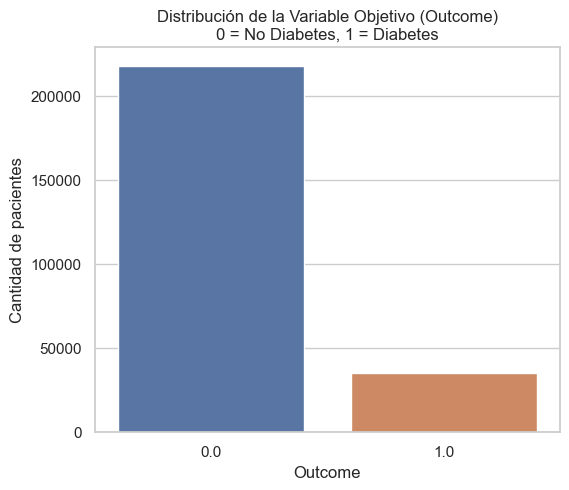


Diabetes_binary
0.0    0.860667
1.0    0.139333
Name: proportion, dtype: float64

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(6, 5))
sns.countplot(x="Diabetes_binary", data=df)

plt.title("Distribución de la Variable Objetivo (Outcome)\n0 = No Diabetes, 1 = Diabetes")
plt.xlabel("Outcome")
plt.ylabel("Cantidad de pacientes")
plt.show()

df["Diabetes_binary"].value_counts(normalize=True)


## 2. Importaciones para modelado y métricas

Se importan las librerías necesarias para entrenamiento, evaluación y visualización del Árbol de Decisión.

In [14]:
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)

## 3. Selección de características

Utilizaremos todas las variables numéricas del dataset como características (`X`) y la variable **Outcome** como objetivo (`y`).

In [17]:
# 3. Selección de características

# X = todas las columnas excepto la variable objetivo
X = df.drop("Diabetes_binary", axis=1)

# y = variable objetivo
y = df["Diabetes_binary"]

print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)

X.head()


Dimensiones de X: (253680, 21)
Dimensiones de y: (253680,)


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


## 4. División de datos en entrenamiento y prueba

Se divide el conjunto en:
- 80% para **entrenamiento**
- 20% para **prueba**

Se utiliza `stratify=y` para conservar la proporción de clases.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print('X_train:', X_train.shape)
print('X_test :', X_test.shape)

X_train: (202944, 21)
X_test : (50736, 21)


## 5. Entrenamiento del modelo Árbol de Decisión (versión base)

Primero se entrena un modelo base con hiperparámetros simples para entender el comportamiento inicial.

In [19]:
dt_base = DecisionTreeClassifier(
    random_state=42,
    max_depth=4,      # profundidad controlada para evitar sobreajuste
    criterion='gini'  # criterio estándar
)

dt_base.fit(X_train, y_train)

y_pred_base = dt_base.predict(X_test)
y_proba_base = dt_base.predict_proba(X_test)[:, 1]

## 6. Métricas de evaluación — Modelo base

Se calculan las métricas principales:
- Accuracy  
- Precision  
- Recall (Sensitivity)  
- F1-score

In [20]:
acc_base = accuracy_score(y_test, y_pred_base)
prec_base = precision_score(y_test, y_pred_base, zero_division=0)
rec_base = recall_score(y_test, y_pred_base, zero_division=0)
f1_base = f1_score(y_test, y_pred_base, zero_division=0)

print('🔍 Métricas modelo base (Árbol de Decisión):\n')
print(f"Accuracy : {acc_base:.4f}")
print(f"Precision: {prec_base:.4f}")
print(f"Recall   : {rec_base:.4f}")
print(f"F1-score : {f1_base:.4f}\n")

print('📋 Classification Report:\n')
print(classification_report(y_test, y_pred_base, zero_division=0))

🔍 Métricas modelo base (Árbol de Decisión):

Accuracy : 0.8607
Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000

📋 Classification Report:

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93     43667
         1.0       0.00      0.00      0.00      7069

    accuracy                           0.86     50736
   macro avg       0.43      0.50      0.46     50736
weighted avg       0.74      0.86      0.80     50736



### 6.1 Matriz de confusión — Modelo base

Se visualiza la matriz de confusión para analizar los aciertos y errores del modelo.

In [21]:
cm_base = confusion_matrix(y_test, y_pred_base)
cm_base


array([[43667,     0],
       [ 7069,     0]])

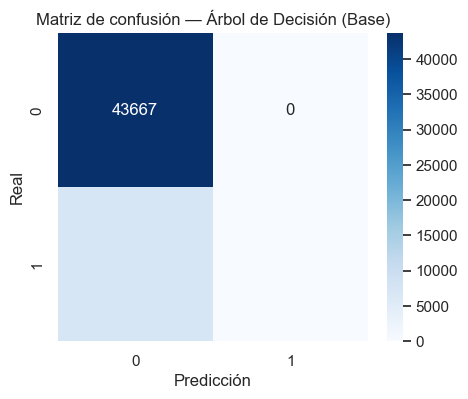

In [22]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión — Árbol de Decisión (Base)')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

### 6.2 Sensitivity y Specificity — Modelo base

- **Sensitivity (Recall de la clase positiva)** = TP / (TP + FN)  
- **Specificity** = TN / (TN + FP)

In [23]:
tn, fp, fn, tp = cm_base.ravel()

sensitivity_base = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity_base = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"Sensitivity (Recall, clase 1): {sensitivity_base:.4f}")
print(f"Specificity (clase 0)        : {specificity_base:.4f}")

Sensitivity (Recall, clase 1): 0.0000
Specificity (clase 0)        : 1.0000


## 7. Curva ROC y Curva Precisión-Recall — Modelo base

Se calculan y visualizan las curvas **ROC** y **Precisión-Recall** para evaluar el rendimiento del modelo en términos de umbrales de decisión.

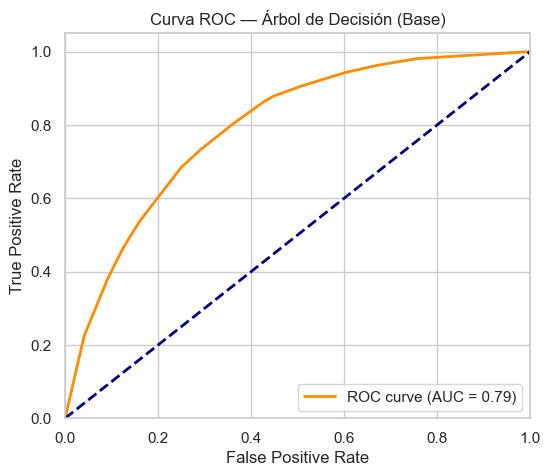

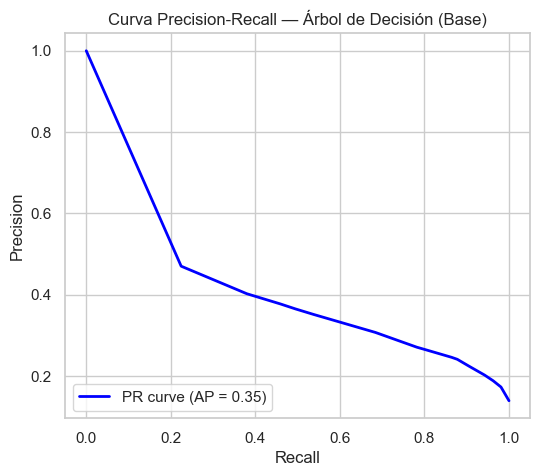

In [24]:
# --- Curva ROC ---
fpr_base, tpr_base, _ = roc_curve(y_test, y_proba_base)
roc_auc_base = auc(fpr_base, tpr_base)

plt.figure(figsize=(6,5))
plt.plot(fpr_base, tpr_base, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc_base:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC — Árbol de Decisión (Base)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- Curva Precisión-Recall ---
precision_base, recall_base, _ = precision_recall_curve(y_test, y_proba_base)
ap_base = average_precision_score(y_test, y_proba_base)

plt.figure(figsize=(6,5))
plt.plot(recall_base, precision_base, color='blue', lw=2,
         label=f'PR curve (AP = {ap_base:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall — Árbol de Decisión (Base)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

## 8. Importancia de características — Modelo base

Los Árboles de Decisión permiten interpretar la importancia relativa de cada variable para la clasificación.

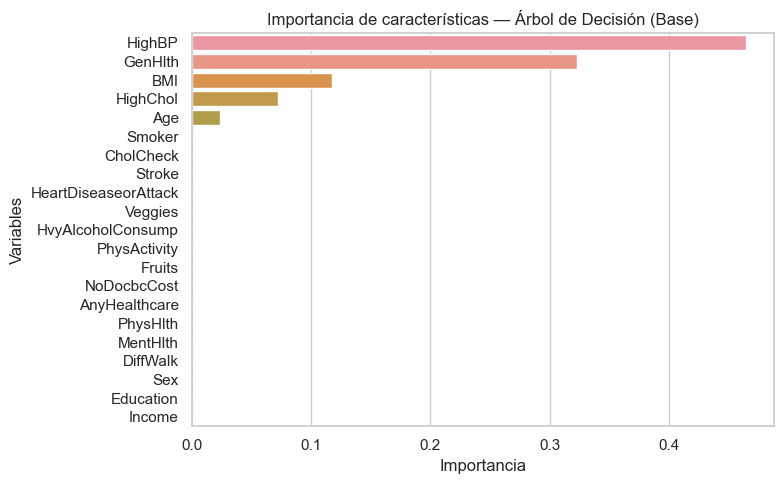


HighBP                  0.465186
GenHlth                 0.322756
BMI                     0.117262
HighChol                0.071704
Age                     0.023092
Smoker                  0.000000
CholCheck               0.000000
Stroke                  0.000000
HeartDiseaseorAttack    0.000000
Veggies                 0.000000
HvyAlcoholConsump       0.000000
PhysActivity            0.000000
Fruits                  0.000000
NoDocbcCost             0.000000
AnyHealthcare           0.000000
PhysHlth                0.000000
MentHlth                0.000000
DiffWalk                0.000000
Sex                     0.000000
Education               0.000000
Income                  0.000000
dtype: float64

In [25]:
feature_importances = pd.Series(dt_base.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title('Importancia de características — Árbol de Decisión (Base)')
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()

feature_importances

## 9. Visualización del Árbol de Decisión (opcional)

A continuación se visualiza el árbol entrenado (cuando la profundidad no es muy grande). Esto permite interpretar reglas de decisión.

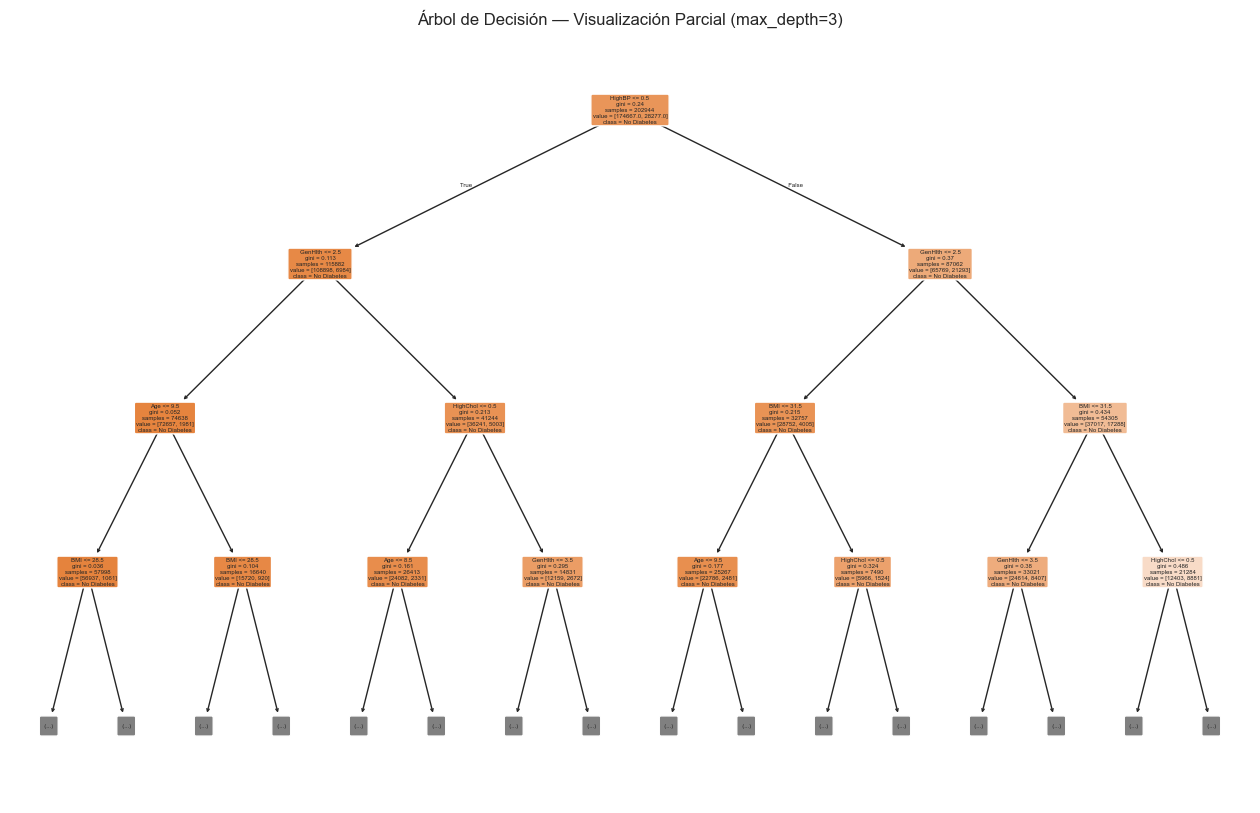

In [26]:
plt.figure(figsize=(16,10))
plot_tree(
    dt_base,
    feature_names=X.columns,
    class_names=['No Diabetes', 'Diabetes'],
    filled=True,
    rounded=True,
    max_depth=3  # limitar profundidad en la visualización
)
plt.title('Árbol de Decisión — Visualización Parcial (max_depth=3)')
plt.show()

## 10. Búsqueda de hiperparámetros con GridSearchCV

Se realiza una búsqueda de hiperparámetros para mejorar el rendimiento del modelo utilizando **GridSearchCV**.

Hiperparámetros a explorar:
- `max_depth`
- `min_samples_split`
- `min_samples_leaf`
- `criterion`

In [27]:
param_grid = {
    'max_depth': [3, 4, 5, 6, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print('Mejores parámetros:', grid_search.best_params_)
print('Mejor accuracy (CV):', round(grid_search.best_score_, 4))

Mejores parámetros: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor accuracy (CV): 0.8649


## 11. Evaluación del mejor modelo (GridSearchCV)

Se evalúa el mejor árbol encontrado por GridSearchCV sobre el conjunto de prueba.

In [28]:
best_dt = grid_search.best_estimator_

y_pred_best = best_dt.predict(X_test)
y_proba_best = best_dt.predict_proba(X_test)[:, 1]

acc_best = accuracy_score(y_test, y_pred_best)
prec_best = precision_score(y_test, y_pred_best, zero_division=0)
rec_best = recall_score(y_test, y_pred_best, zero_division=0)
f1_best = f1_score(y_test, y_pred_best, zero_division=0)

print('🔍 Métricas mejor modelo (GridSearchCV — Árbol de Decisión):\n')
print(f"Accuracy : {acc_best:.4f}")
print(f"Precision: {prec_best:.4f}")
print(f"Recall   : {rec_best:.4f}")
print(f"F1-score : {f1_best:.4f}\n")

print('📋 Classification Report (Best Model):\n')
print(classification_report(y_test, y_pred_best, zero_division=0))

🔍 Métricas mejor modelo (GridSearchCV — Árbol de Decisión):

Accuracy : 0.8643
Precision: 0.5829
Recall   : 0.0925
F1-score : 0.1597

📋 Classification Report (Best Model):

              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93     43667
         1.0       0.58      0.09      0.16      7069

    accuracy                           0.86     50736
   macro avg       0.73      0.54      0.54     50736
weighted avg       0.83      0.86      0.82     50736



### 11.1 Matriz de confusión — Mejor modelo


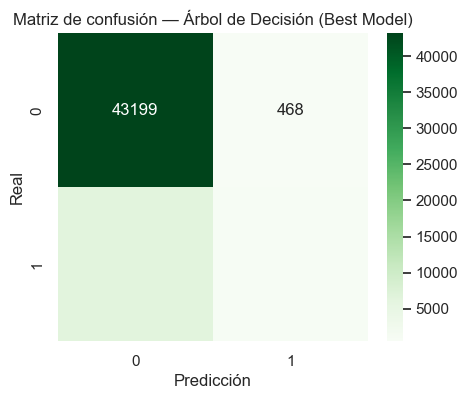


array([[43199,   468],
       [ 6415,   654]])

In [29]:
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de confusión — Árbol de Decisión (Best Model)')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

cm_best

### 11.2 Sensitivity y Specificity — Mejor modelo


In [30]:
tn_b, fp_b, fn_b, tp_b = cm_best.ravel()

sensitivity_best = tp_b / (tp_b + fn_b) if (tp_b + fn_b) > 0 else 0
specificity_best = tn_b / (tn_b + fp_b) if (tn_b + fp_b) > 0 else 0

print(f"Sensitivity (Best Model): {sensitivity_best:.4f}")
print(f"Specificity (Best Model): {specificity_best:.4f}")

Sensitivity (Best Model): 0.0925
Specificity (Best Model): 0.9893


### 11.3 Curva ROC y Curva PR — Mejor modelo


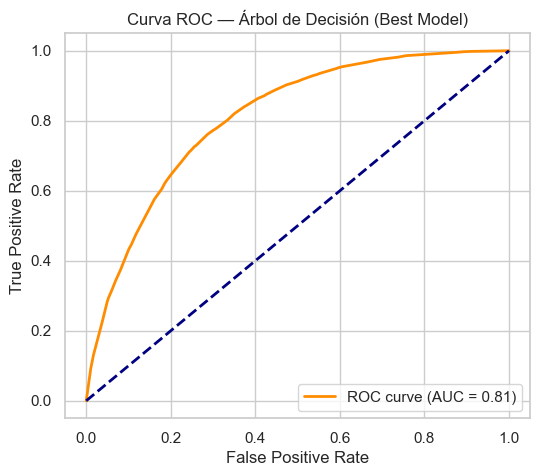

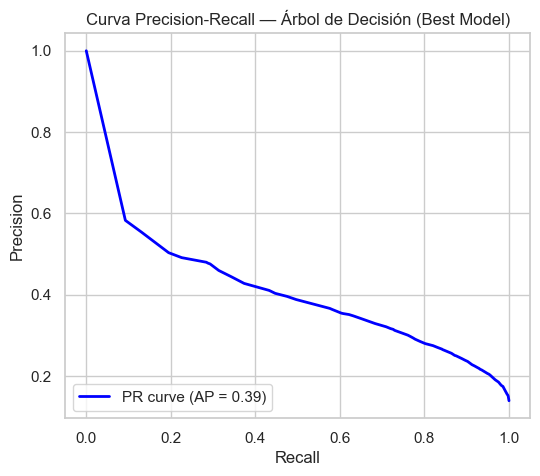

In [31]:
# --- Curva ROC (Best Model) ---
fpr_b, tpr_b, _ = roc_curve(y_test, y_proba_best)
roc_auc_b = auc(fpr_b, tpr_b)

plt.figure(figsize=(6,5))
plt.plot(fpr_b, tpr_b, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc_b:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC — Árbol de Decisión (Best Model)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- Curva Precision-Recall (Best Model) ---
precision_b, recall_b, _ = precision_recall_curve(y_test, y_proba_best)
ap_b = average_precision_score(y_test, y_proba_best)

plt.figure(figsize=(6,5))
plt.plot(recall_b, precision_b, color='blue', lw=2,
         label=f'PR curve (AP = {ap_b:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall — Árbol de Decisión (Best Model)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()